In [2]:
%run __init__.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from itertools import combinations
from tools import *
from before_stack import *
from conversion import *
from aper_phot import *
from cr_to_flux import *
mon = 'dec'

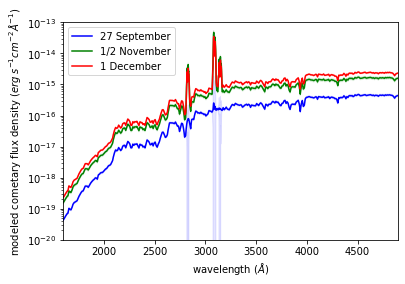

In [3]:
spec_name_sun = 'sun_1A.txt'
spec_name_OH = '2019-07-15_emission_models_OH.txt'
r = 0
sep_cr_uw1 = (0.14973177655459663, 0.020716411744605753)
sep_cr_v = (1.596472105364322, 0.1215467927106162)
nov_cr_uw1 = (1.2245082389583428, 0.08214245131095835)
nov_cr_v = (5.777901523015753, 0.584814703003602)
dec_cr_uw1 = (1.2793946304469037, 0.05811461087705628)
dec_cr_v = (8.436121829096756, 0.46064944712741507)

sep_factors = flux_cr_spec(spec_name_sun, 
                           spec_name_OH,
                           sep_cr_uw1[0], 
                           sep_cr_uw1[1], 
                           sep_cr_v[0], 
                           sep_cr_v[1], r)

nov_factors = flux_cr_spec(spec_name_sun, 
                           spec_name_OH,
                           nov_cr_uw1[0], 
                           nov_cr_uw1[1], 
                           nov_cr_v[0], 
                           nov_cr_v[1], r)

dec_factors = flux_cr_spec(spec_name_sun, 
                           spec_name_OH,
                           dec_cr_uw1[0], 
                           dec_cr_uw1[1], 
                           dec_cr_v[0], 
                           dec_cr_v[1], r)

sep_sum_wave, sep_sum_flux, sep_sum_flux_err = sum_spec(spec_name_OH, sep_factors[4], sep_factors[5], spec_name_sun, sep_factors[0], sep_factors[1])

nov_sum_wave, nov_sum_flux, nov_sum_flux_err = sum_spec(spec_name_OH, nov_factors[4], nov_factors[5], spec_name_sun, nov_factors[0], nov_factors[1])

dec_sum_wave, dec_sum_flux, dec_sum_flux_err = sum_spec(spec_name_OH, dec_factors[4], dec_factors[5], spec_name_sun, dec_factors[0], dec_factors[1])

plt.plot(sep_sum_wave, sep_sum_flux, 'b-', label='27 September')
plt.fill_between(sep_sum_wave, sep_sum_flux-sep_sum_flux_err, sep_sum_flux+sep_sum_flux_err, color='b',alpha=0.1)

plt.plot(nov_sum_wave, nov_sum_flux, 'g-', label='1/2 November')
plt.fill_between(nov_sum_wave, nov_sum_flux-nov_sum_flux_err, nov_sum_flux+nov_sum_flux_err, color='g',alpha=0.1)

plt.plot(dec_sum_wave, dec_sum_flux, 'r-', label='1 December')
plt.fill_between(dec_sum_wave, dec_sum_flux-dec_sum_flux_err, dec_sum_flux+dec_sum_flux_err, color='r',alpha=0.1)

plt.xlabel(r'wavelength ($\AA$)')
plt.ylabel(r'modeled cometary flux density ($erg \; s^{-1} cm^{-2} \AA^{-1}$)')
plt.xlim(1600, 4900)
plt.ylim(1e-20, 1e-13)
plt.legend()
plt.yscale('log')
plt.show()

In [4]:
# aperture photometry
# src_method = 'count', 'median'
# bg_method = 'circle_mean', 'circle_median', 'donut_mean', 'donut_median', 'multi_mean'
def q(mon, aperture):
    src_r = aperture
    spec_name_sun = 'sun_1A.txt'
    spec_name_OH = '2019-07-15_emission_models_OH.txt'
    spec_name_sum = 'cont_emis_sum.txt'
    src_center = (1000, 1000)
    if mon == 'sep':
        img_name_uw1 = 'sep_stack_uw1.fits'
        img_name_v = 'sep_stack_part_uvv.fits'
        bg_reg_name_uw1 = 'sep_bg_uw1_new.reg'
        bg_reg_name_v = 'sep_bg_uvv_new.reg'
    if mon == 'nov':
        img_name_uw1 = 'nov_stack_uw1.fits'
        img_name_v = 'nov_stack_uvv.fits'
        bg_reg_name_uw1 = 'nov_bg_uw1_new.reg'
        bg_reg_name_v = 'nov_bg_uvv_new.reg'
    if mon == 'dec':
        img_name_uw1 = 'dec_stack_uw1.fits'
        img_name_v = 'dec_stack_uvv.fits'
        bg_reg_name_uw1 = 'dec_bg_uw1_new.reg'
        bg_reg_name_v = 'dec_bg_uvv_new.reg'
    # uw1

    bg_uw1 = load_reg_list(bg_reg_name_uw1)
    bg_x_uw1 = bg_uw1[1]
    bg_y_uw1 = bg_uw1[0]
    bg_r_uw1 = bg_uw1[2]
    bg_center_uw1 = list(zip(bg_x_uw1, bg_y_uw1))
    bg_v = load_reg_list(bg_reg_name_v)
    bg_x_v = bg_v[1]
    bg_y_v = bg_v[0]
    bg_r_v = bg_v[2]
    bg_center_v = list(zip(bg_x_v, bg_y_v))

    result_uw1 = aper_phot(img_name_uw1, 'uw1', 
                           #src_center_uw1, src_r_uw1, 
                           src_center, src_r,
                           bg_center_uw1, bg_r_uw1,
                           'count', 'multi_mean')


    cr_uw1, cr_uw1_err = result_uw1[0]
    snr_uw1 = result_uw1[1]
    mag_uw1, mag_uw1_err = result_uw1[2]
    bg_cr_uw1, bg_cr_uw1_err = result_uw1[3]

    result_v = aper_phot(img_name_v, 'v',
                         #src_center_v, src_r_v, 
                         src_center, src_r,
                         bg_center_v, bg_r_v,
                         'count', 'multi_mean')

    cr_v, cr_v_err = result_v[0]
    snr_v = result_v[1]
    mag_v, mag_v_err = result_v[2]
    bg_cr_v, bg_cr_v_err = result_v[3]

    # calculate OH
    # method = 'cr', 'flux_cf', 'flux_my_cf', 'flux_cr'
    flux, flux_err = get_OH('flux_cr', 
                            spec_name_sun, 
                            spec_name_OH, 
                            spec_name_sum,
                            cr_uw1, cr_uw1_err,
                            cr_v, cr_v_err,
                            0)

    obs_log_name = mon+'_obs-log_Borisov.txt'
    wvm_name = mon+'_wvm.txt'

    num, num_err = flux2num(flux, flux_err, 
                            'fluorescenceOH.txt', 
                            obs_log_name, 
                            method='both_ends', 
                            horizon_id=90004424)

    q, q_err = num2q(num, num_err, 
                     wvm_name, aperture=src_r)
    return q, q_err

def q_aper(mon, aperture_list):
    q_list = []
    q_err_list = []
    for aperture in aperture_list:
        q_i, q_err_i = q(mon, aperture)
        q_list.append(q_i)
        q_err_list.append(q_err_i)
    return q_list, q_err_list

def mon2aper_list(mon):
    if mon == 'sep':
        aper1 = np.arange(2, 15, 1)
        aper2 = np.arange(15, 105, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'nov':
        aper1 = np.arange(2, 50, 1)
        aper2 = np.arange(50, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'dec':
        aper1 = np.arange(2, 40, 1)
        aper2 = np.arange(40, 105, 5)
        return np.concatenate((aper1, aper2))

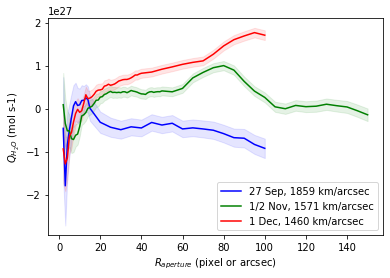

In [5]:
sep_aper_list = mon2aper_list('sep')
sep_q_list, sep_q_err_list = q_aper('sep', sep_aper_list)
sep_aper_list = np.array(sep_aper_list)
sep_q_list = np.array(sep_q_list)
sep_q_err_list = np.array(sep_q_err_list)
plt.plot(sep_aper_list, sep_q_list, 'b', label='27 Sep, 1859 km/arcsec')
plt.fill_between(sep_aper_list, sep_q_list-sep_q_err_list, sep_q_list+sep_q_err_list, color='b',alpha=0.1)

nov_aper_list = mon2aper_list('nov')
nov_q_list, nov_q_err_list = q_aper('nov', nov_aper_list)
nov_aper_list = np.array(nov_aper_list)
nov_q_list = np.array(nov_q_list)
nov_q_err_list = np.array(nov_q_err_list)
plt.plot(nov_aper_list, nov_q_list, 'g', label='1/2 Nov, 1571 km/arcsec')
plt.fill_between(nov_aper_list, nov_q_list-nov_q_err_list, nov_q_list+nov_q_err_list, color='g',alpha=0.1)

dec_aper_list = mon2aper_list('dec')
dec_q_list, dec_q_err_list = q_aper('dec', dec_aper_list)
dec_aper_list = np.array(dec_aper_list)
dec_q_list = np.array(dec_q_list)
dec_q_err_list = np.array(dec_q_err_list)
plt.plot(dec_aper_list, dec_q_list, 'r', label='1 Dec, 1460 km/arcsec')
plt.fill_between(dec_aper_list, dec_q_list-dec_q_err_list, dec_q_list+dec_q_err_list, color='r',alpha=0.1)

plt.legend()
plt.xlabel(r'$R_{aperture}$ (pixel or arcsec)')
plt.ylabel(r'$Q_{H_2O}$ (mol s-1)')
plt.show()

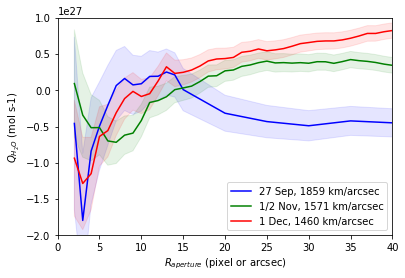

In [6]:
plt.plot(sep_aper_list, sep_q_list, 'b', label='27 Sep, 1859 km/arcsec')
plt.fill_between(sep_aper_list, sep_q_list-sep_q_err_list, sep_q_list+sep_q_err_list, color='b',alpha=0.1)
plt.plot(nov_aper_list, nov_q_list, 'g', label='1/2 Nov, 1571 km/arcsec')
plt.fill_between(nov_aper_list, nov_q_list-nov_q_err_list, nov_q_list+nov_q_err_list, color='g',alpha=0.1)
plt.plot(dec_aper_list, dec_q_list, 'r', label='1 Dec, 1460 km/arcsec')
plt.fill_between(dec_aper_list, dec_q_list-dec_q_err_list, dec_q_list+dec_q_err_list, color='r',alpha=0.1)
plt.legend()
plt.xlim(0,40)
plt.ylim(-2e27,1e27)
plt.xlabel(r'$R_{aperture}$ (pixel or arcsec)')
plt.ylabel(r'$Q_{H_2O}$ (mol s-1)')
plt.show()